#

# Introduction:

This study examines the relationship between demographic characteristics, particularly age and video game engagement, with the aim of understanding how these factors influence player behavior and total playtime. By identifying patterns across demographic groups, we seek to uncover which types of players are most likely to contribute substantial gameplay data.

The analysis draws on data collected in collaboration with Professor Frank Wood’s research group in the Department of Computer Science at the University of British Columbia. Player activity was recorded through a custom-built Minecraft server, resulting in two primary datasets: players.csv, which contains demographic information and self-reported gaming experience, and sessions.csv, which logs individual gameplay sessions over time.

While the broader goal of the research conducted by Wood is to better understand how individuals engage with video games, our specific focus is to investigate the role of age as a predictor of engagement, as measured by total hours played. Gaining insight into this relationship can inform more effective participant recruitment strategies by identifying demographics most likely to contribute high volumes of gameplay data.

Therefore, the central research question guiding this report is:
To what extent can age predict the number of hours a person plays?


# Methods and Results:

##### Relevant Variables

Age (dbl): Player’s self-reported age. This player characteristic will also be used in regression and demographic analyses.
played_hours (dbl): Total number of hours the player has spent in the game, aggregated from session data. This variable serves as our dependent variable, as it is the best proxy for overall engagement.


Starting off, we will load in the necessary data and libraries

In [69]:
library(tidyverse)
library(tidymodels)
player_data <- read_csv("https://raw.githubusercontent.com/nyue324/Dsci100-project/refs/heads/main/players.csv")
set.seed(123)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [70]:
The data needs to be prepped and different summaries of the dataset are taken to give us a greater understanding of our observations

ERROR: Error in parse(text = x, srcfile = src): <text>:1:5: unexpected symbol
1: The data
        ^


In [71]:
# 1. Data Preparation

player_data_filtered <- player_data |>
    select(played_hours, Age)
player_data_means <- player_data_filtered |>
    summarize(average_age = mean(Age,na.rm=TRUE), average_playtime = mean(played_hours))
player_data_means
player_data_maxes <- player_data_filtered |>
    summarize(max_age = max(Age,na.rm=TRUE), max_playtime = max(played_hours))
player_data_maxes
player_data_mins <- player_data_filtered |>
    summarize(minimum_age = min(Age,na.rm=TRUE), minimum_playtime = min(played_hours))
player_data_mins

average_age,average_playtime
<dbl>,<dbl>
20.52062,5.845918


max_age,max_playtime
<dbl>,<dbl>
50,223.1


minimum_age,minimum_playtime
<dbl>,<dbl>
8,0


The dataset is first visualized to give us a picture of what the data looks like

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


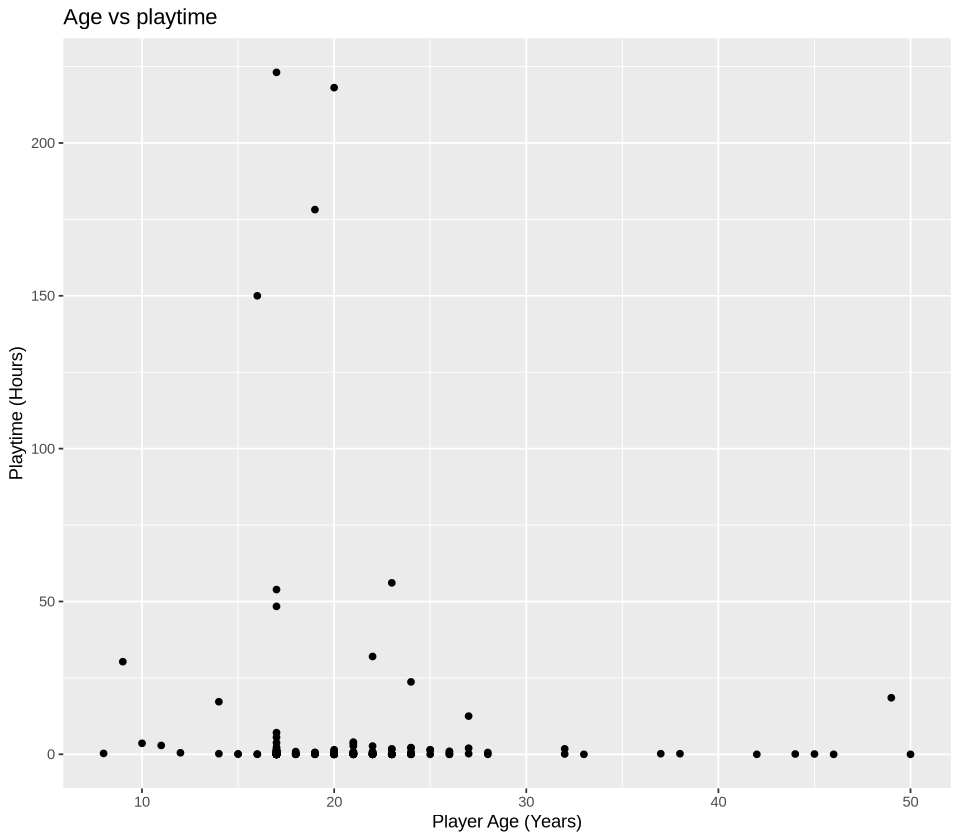

In [72]:
# 2. Visualization of dataset

player_plot <- player_data_filtered |> 
ggplot(aes(x=Age,y=played_hours))+
geom_point()+
xlab("Player Age (Years)")+
ylab("Playtime (Hours)")+
ggtitle("Age vs playtime")
player_plot

In order to start the analysis, the data is split into a training and testing set

In [73]:
# 3. Train/Test Split (Stratify by Age)

players_split <- initial_split(player_data_filtered, prop = 0.75, strata = Age)
players_training <- training(players_split)
players_testing <- testing(players_split)

We set up the analysis by setting Age as a predictor for played hours, specify that we are using linear regression, create a workflow, and fit the model.

In [74]:
# 4. Define Recipe

lm_recipe <- recipe(played_hours ~ Age, data = players_training)

# 5. Model Specification

lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

# 6. Workflow Creation and Model Fitting

lm_workflow <- workflow() |>
  add_recipe(lm_recipe) |>
  add_model(lm_spec) |>
  fit(data = players_training)

Here we make our predictions on the testing set and compare the predicted values to our actual values

In [75]:
# 7. Predict on Test Set

predictions <- predict(lm_workflow, new_data = players_testing) |>
  bind_cols(players_testing)

# 8. Evaluate Model Performance

lm_metrics <- predictions |>
  metrics(truth = played_hours, estimate = .pred)

lm_rmspe <- lm_metrics |>
  filter(.metric == "rmse") |>
  pull(.estimate)
print(lm_metrics)

# A tibble: 3 × 3
  .metric .estimator  .estimate
  <chr>   <chr>           <dbl>
1 rmse    standard   31.0      
2 rsq     standard    0.0000215
3 mae     standard   10.7      


Lastly, we visualize the predictions as a line overlaying a scatter plot of the actual values

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


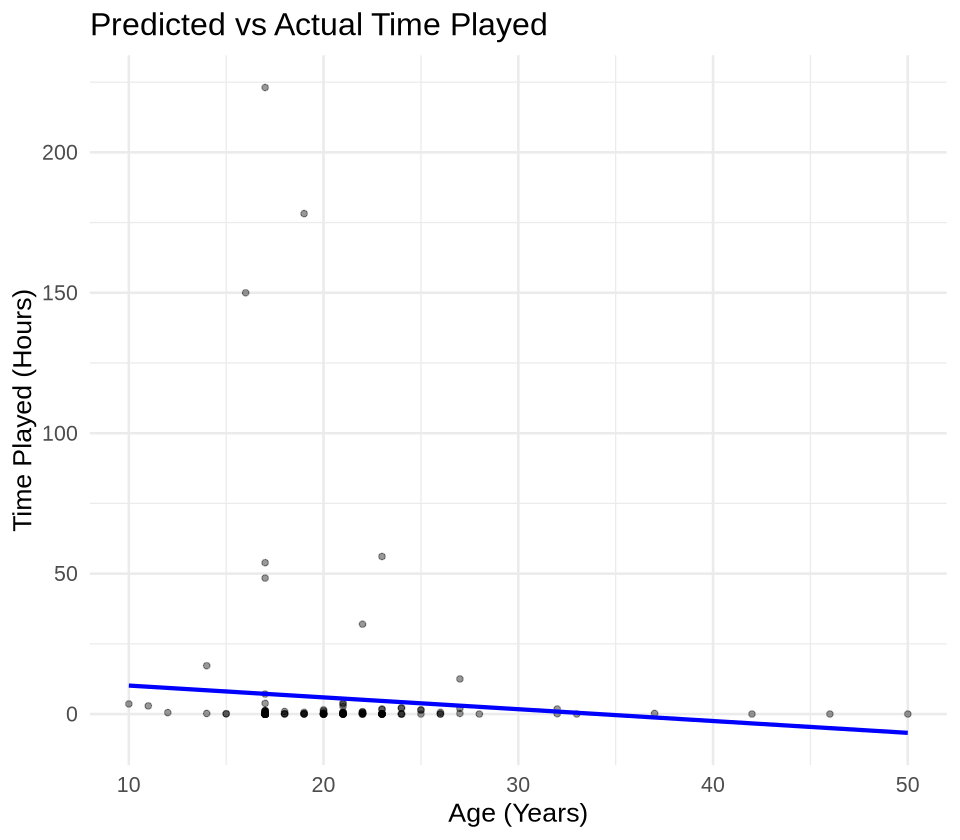

In [76]:
# 9. Visualize Predictions (on Training Set)

training_preds <- predict(lm_workflow, new_data = players_training) |>
  bind_cols(players_training)

lm_plot <- training_preds |>
  ggplot(aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.4) +
  geom_line(aes(y = .pred), color = "blue", linewidth = 1.2) +
  labs(title = "Predicted vs Actual Time Played",
    x = "Age (Years)",
    y = "Time Played (Hours)") +
  theme_minimal(base_size = 16)
lm_plot

# Discussion:
#### Evaluation of the model:
Taking the result at face value, the regression results suggest a weak negative relationship between age and total playtime. In other words, younger players tend to engage more with the game, while older players generally log fewer hours. This could reflect lifestyle differences—such as younger players having more discretionary time or being more intrinsically motivated to explore sandbox games like Minecraft.
However, from the linear regression model, we calculate the following model metrics to assess the validity of this model:
#### RMSE (Root Mean Squared Error): 
31.0
#### R² (R-squared): 
0.0000215
#### MAE (Mean Absolute Error): 
10.7

Based on these metrics, we can derive three key insights:
R^2 (0.0000215): This value is extremely close to zero, which means the model explains virtually none of the variance in video game playtime. In other words, age alone has no meaningful predictive power in this model. The predicted values are barely better than using the mean playtime for all observations. This strongly suggests that age alone is not a reliable predictor of engagement.
RMSE (31.0): An RMSE of 31 means that, on average, the model’s predictions deviate from the actual playtime by 31 hours. Given that the mean for played_hours is around 5.84 hours, with played_hours only having a range of 0-223.1 (see Methods and Results), this is a very large error, highlighting poor predictive performance.
MAE (10.7): The MAE is slightly more forgiving than RMSE, showing an average error of 10.7 hours per prediction. This is still quite large when looking at the played_hours variable in relative terms, and reinforces the same conclusion: age alone does not offer a strong or reliable signal for estimating gameplay behavior.

Based on the results, the linear regression model demonstrates that age alone is a weak predictor of playtime in Minecraft. In fact, contrary to common assumptions, age may have little to no influence on player engagement with the game.


#### Model Limitations:
While this model does lead to a strong conclusion that age is a poor predictor of player engagement, it’s important to recognize the limitations of using a simple linear regression:
#### Oversimplification:
Using age as the sole predictor overlooks key behavioral and motivational factors that likely play a more substantial role in determining player engagement. For instance, two individuals of the same age may differ significantly in their interest in gaming, habitual playtime, or availability of free time.
To address this limitation, future models should incorporate additional variables or control for confounding factors that may influence engagement. For example, the players.csv dataset includes a self-reported experience variable, which could be stratified to build more targeted linear models. This would allow us to explore whether older, more experienced players demonstrate higher levels of engagement compared to less experienced peers, thereby revealing more nuanced patterns in the data.
#### Non-linearity: 
The relationship between age and engagement may not be strictly linear. For example, teens may play more than both younger children and older adults, suggesting a possible peak in engagement during adolescence.
To account for this, nonlinear models (e.g., polynomial regression or spline regression) could be used to capture more complex age-related patterns.
#### External Variables: 
Workload, access to gaming devices, and social context all influence gameplay behavior but are not captured in the current model. A university student during finals season, for example, may play less than a peer on break.
To mitigate this, future studies could include survey-based data collection on lifestyle factors, device accessibility, and daily routines to better contextualize playtime.
#### Dataset Bias: 
Since the sample is drawn exclusively from Minecraft server users, there is a potential self-selection bias toward younger and more intrinsically engaged players. For example, while Minecraft tends to appeal to a younger demographic due to its creative and non-violent nature, a more mature or action-oriented game—such as Mortal Kombat II—might be more engaging for older players.
Although this study focused solely on Minecraft, if the primary goal is to identify the types of gamers who generate the most valuable engagement data for future research, it would be beneficial to diversify sampling methods. This could include recruiting participants across a range of platforms, age groups, and game genres to ensure a more representative and generalizable dataset.


# Conclusion


In conclusion, our linear regression analysis using the provided datasets (players.csv and sessions.csv) reveals an inconclusive result to the research question: To what extent can age predict the number of hours a person plays?

We found through evaluating our model that age alone is a poor predictor of total playtime in Minecraft, with model metrics indicating minimal explanatory power and high prediction error. While the regression results suggest a weak negative trend between age and engagement, the model's simplicity limits its validity as well, which raises concerns about the replicability of the findings. Real-life engagement patterns are influenced by a variety of behavioral, contextual, and motivational factors that a single-variable model cannot capture.

To enhance predictive performance and uncover more meaningful patterns, future models should incorporate additional variables such as player experience, session count, or lifestyle context. The self-reported experience metric in particular shows potential for stratifying players into more informative subgroups. This will improve both the robustness and generalizability of our findings.

Ultimately, while our current model provides a foundational insight that there is a negligible relationship between age and engagement, a more nuanced and multi-variable approach is necessary to accurately model gameplay behavior and engagement across diverse player profiles.
